In [34]:
root_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/"
path_pesi_old = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/pesi/pesi.h5"
history_saving_path_json = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/history.json"
save_checkpoints_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt"
path_root = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware"

In [35]:
class_index = {'Adialer.C': 0,
              'Agent.FYI': 1,
              'Allaple.A': 2,
              'Allaple.L': 3,
              'Alueron.gen!J': 4,
              'Autorun.K': 5,
              'Benign': 6,
              'C2LOP.P': 7,
              'C2LOP.gen!g': 8,
              'Dialplatform.B': 9,
              'Dontovo.A': 10,
              'Fakerean': 11,
              'Instantaccess': 12,
              'Lolyda.AA1': 13,
              'Lolyda.AA2': 14,
              'Lolyda.AA3': 15,
              'Lolyda.AT': 16,
              'Malex.gen!J': 17,
              'Obfuscator.AD': 18,
              'Rbot!gen': 19,
              'Skintrim.N': 20,
              'Swizzor.gen!E': 21,
              'Swizzor.gen!I': 22,
              'VB.AT': 23,
              'Wintrim.BX': 24,
              'Yuner.A': 25}

# **Setting up the dataset**

In [36]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:

import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd


In [38]:
train_df_partial=pd.read_csv(os.path.join(path_root,"train_combined3.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_combined3.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_combined3.csv"))


train_df =pd.concat([train_df_partial, val_df], ignore_index = True)

In [39]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 8347 validated image filenames belonging to 26 classes.
Found 2074 validated image filenames belonging to 26 classes.


In [40]:

classes = train_gen.class_indices

# **Analysis of class distribution for each subset**

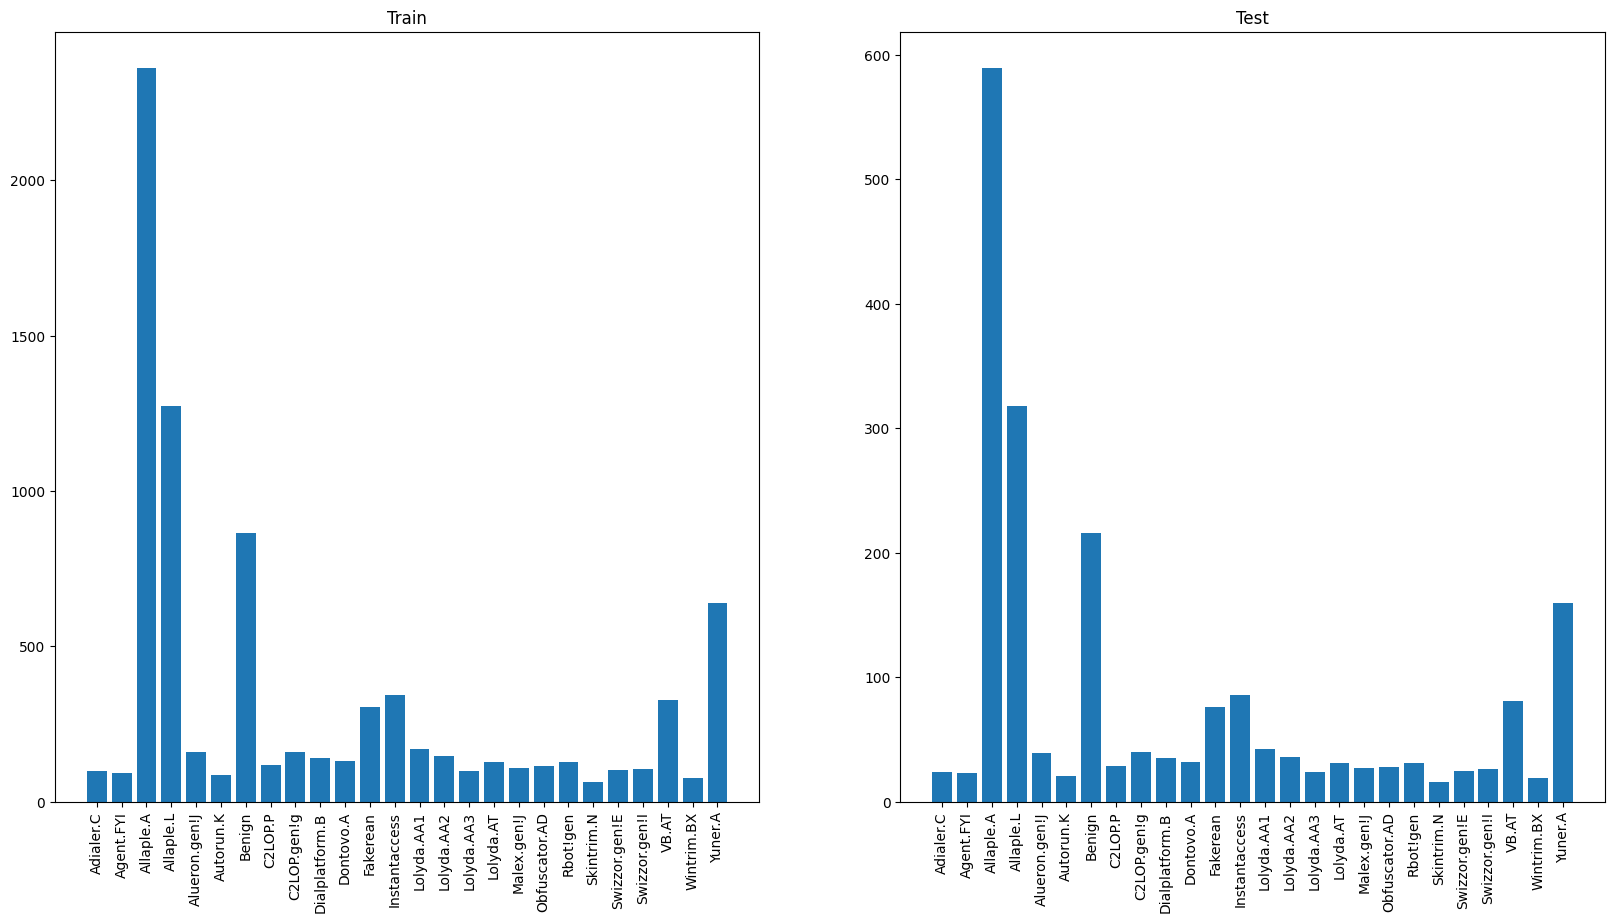

In [41]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ]
name = ["Train", "Test"]

plt.figure(figsize = (20,10))

for i in range(2):

  plt.subplot(1,2,i+1)
  plt.title(name[i])
  plt.xticks(rotation = "vertical")
  plt.bar(classes.keys(), occur[i])

plt.show()

# **Class weight calculation**

In [42]:
train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [43]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights


{0: 3.2759026687598114,
 1: 3.4520264681555006,
 2: 0.13603324641460235,
 3: 0.2521904646806454,
 4: 2.0191098209966136,
 5: 3.776923076923077,
 6: 0.3707141588203944,
 7: 2.7439184746877054,
 8: 2.0064903846153848,
 9: 2.2608342361863487,
 10: 2.469526627218935,
 11: 1.0525851197982345,
 12: 0.9305462653288741,
 13: 1.877417903733693,
 14: 2.1691787941787943,
 15: 3.2428127428127427,
 16: 2.508112980769231,
 17: 2.9453069865913903,
 18: 2.81612685560054,
 19: 2.52786190187765,
 20: 5.016225961538462,
 21: 3.1168782673637043,
 22: 3.02866473149492,
 23: 0.9817689955304634,
 24: 4.115877712031558,
 25: 0.5016225961538462}

<BarContainer object of 26 artists>

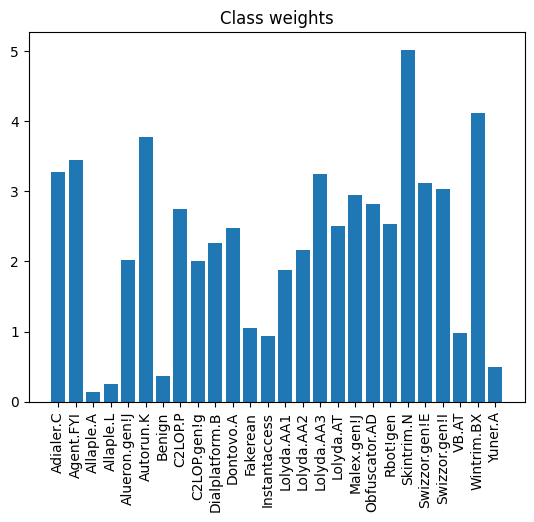

In [44]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

# **Building the CNN**

In [45]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy


In [46]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

In [47]:
Malware_model = malware_model()
Malware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 32)       

In [48]:

cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")

In [49]:
#Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

# **Training**

In [50]:
history = Malware_model.fit(train_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
261/261 [==============================] - ETA: 0s - loss: 2.4793 - accuracy: 0.2343 - weighted_accuracy: 0.2820
Epoch 1: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt
261/261 [==============================] - 2061s 8s/step - loss: 2.4793 - accuracy: 0.2343 - weighted_accuracy: 0.2820
Epoch 2/10
261/261 [==============================] - ETA: 0s - loss: 1.1217 - accuracy: 0.6510 - weighted_accuracy: 0.6624
Epoch 2: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckpt
261/261 [==============================] - 741s 3s/step - loss: 1.1217 - accuracy: 0.6510 - weighted_accuracy: 0.6624
Epoch 3/10
261/261 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.7824 - weighted_accuracy: 0.7759
Epoch 3: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/modellozzo_ckp

# **History saving**

In [51]:

hist_df = pd.DataFrame(history.history)
with open(history_saving_path_json, 'wb') as file_pi:
    hist_df.to_json(file_pi)

# **Model training plots**

dict_keys(['loss', 'accuracy', 'weighted_accuracy'])


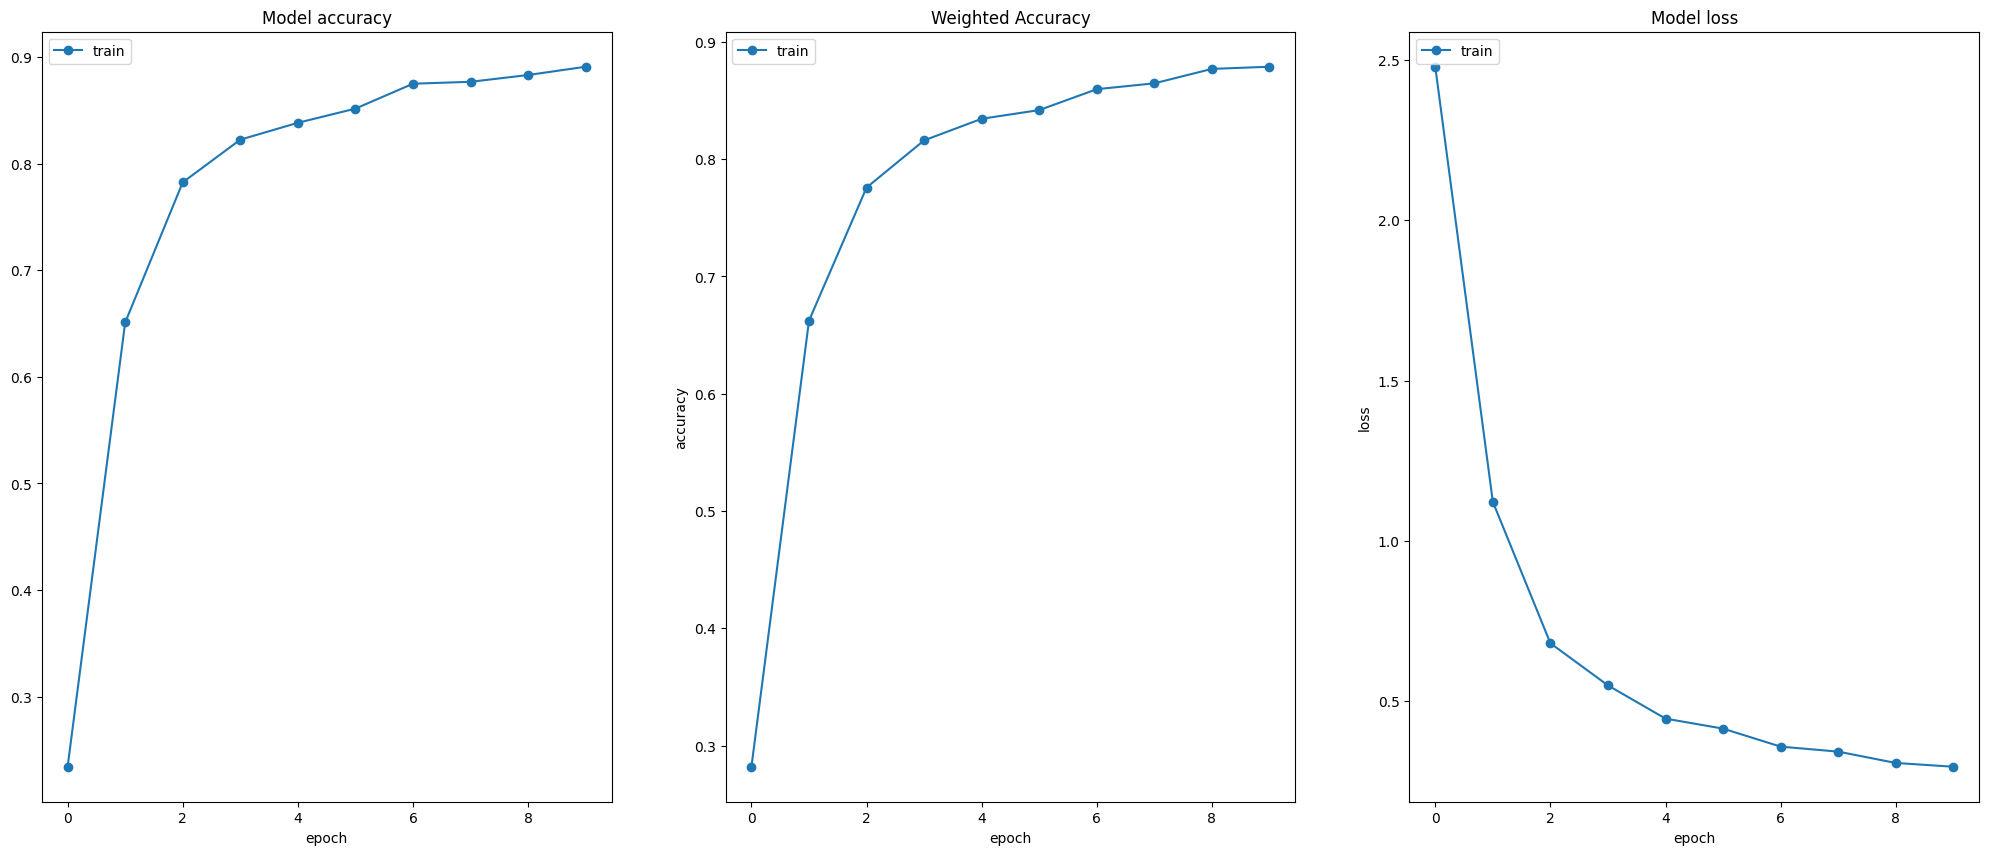

In [52]:
print(history.history.keys())
plt.figure(figsize = (25,10))
#  "Accuracy"
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1,3,2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# **Results on Test Set**

In [53]:

metric_list = Malware_model.evaluate(test_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

65/65 [==============================] - 804s 13s/step - loss: 0.2660 - accuracy: 0.8814 - weighted_accuracy: 0.8814
evaluate_accuracy=0.881
evaluate_weighted_accuracy=0.881


# **Confusion matrix**

In [54]:

y_pred = Malware_model.predict(test_gen)
y_test_predicted = np.argmax(np.array(y_pred),axis = 1)

65/65 [==============================] - 52s 793ms/step


In [58]:
c_matrix = metrics.confusion_matrix(test_gen.classes, y_test_predicted)
df_confusion = pd.crosstab(test_gen.classes, y_test_predicted)
df_confusion.to_csv(os.path.join(root_path,"confusion_matrix.csv"))

In [55]:

from sklearn import metrics

In [56]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

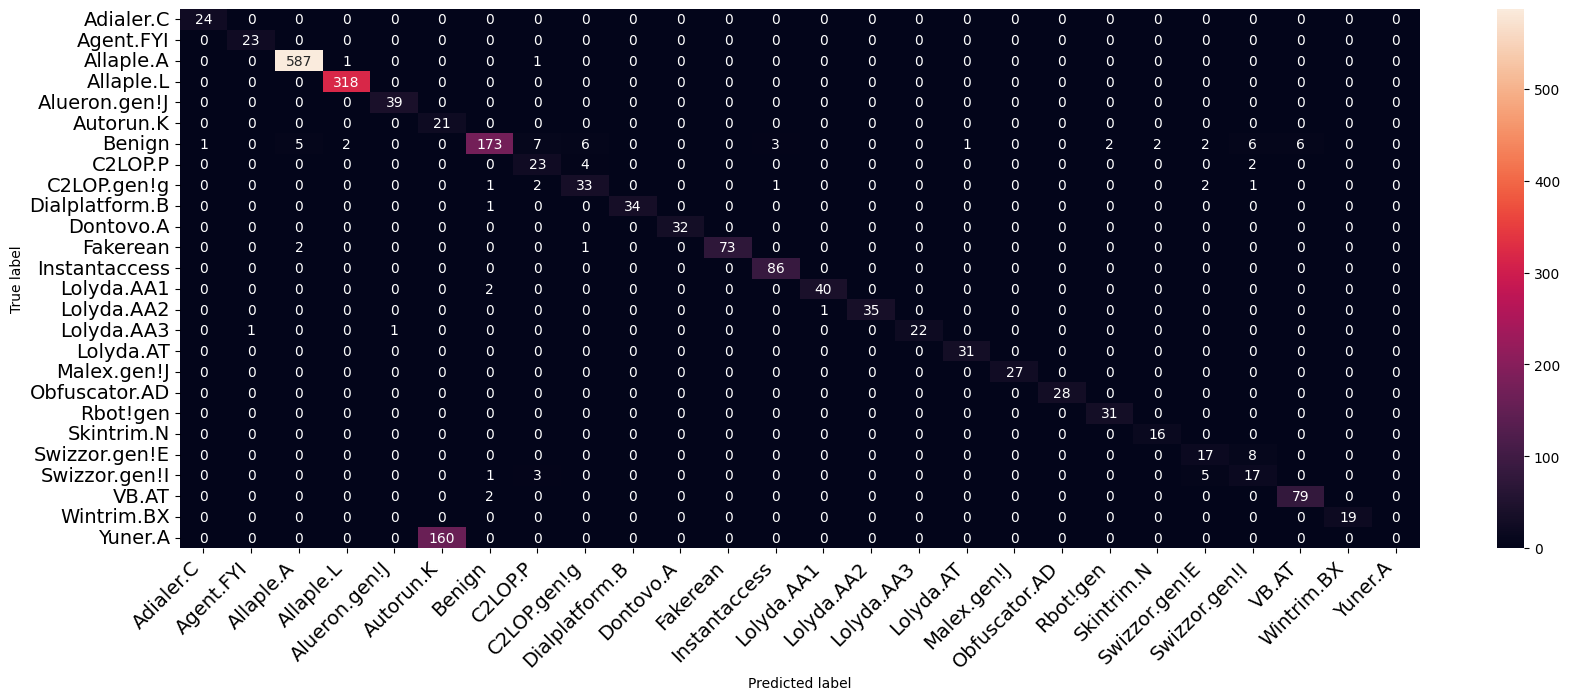

In [59]:
confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [60]:
report = metrics.classification_report(test_gen.classes, y_test_predicted, target_names=classes,  output_dict=True)
print(report)

{'Adialer.C': {'precision': 0.96, 'recall': 1.0, 'f1-score': 0.9795918367346939, 'support': 24}, 'Agent.FYI': {'precision': 0.9583333333333334, 'recall': 1.0, 'f1-score': 0.9787234042553191, 'support': 23}, 'Allaple.A': {'precision': 0.9882154882154882, 'recall': 0.9966044142614601, 'f1-score': 0.992392223161454, 'support': 589}, 'Allaple.L': {'precision': 0.9906542056074766, 'recall': 1.0, 'f1-score': 0.9953051643192489, 'support': 318}, 'Alueron.gen!J': {'precision': 0.975, 'recall': 1.0, 'f1-score': 0.9873417721518987, 'support': 39}, 'Autorun.K': {'precision': 0.11602209944751381, 'recall': 1.0, 'f1-score': 0.2079207920792079, 'support': 21}, 'Benign': {'precision': 0.9611111111111111, 'recall': 0.8009259259259259, 'f1-score': 0.8737373737373737, 'support': 216}, 'C2LOP.P': {'precision': 0.6388888888888888, 'recall': 0.7931034482758621, 'f1-score': 0.7076923076923076, 'support': 29}, 'C2LOP.gen!g': {'precision': 0.75, 'recall': 0.825, 'f1-score': 0.7857142857142856, 'support': 40},

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:

df_report = pd.DataFrame(report).transpose()
df_report = df_report.round({'precision': 5, 'recall': 5, 'f1-score': 5})
df_report.to_csv(os.path.join(root_path,"report.csv"))